[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mlvlab/KCCV2023_TokenMixup_Tutorial/blob/main/KCCV2023_SageMix.ipynb)

# KCCV2023_SageMix_Tutorial

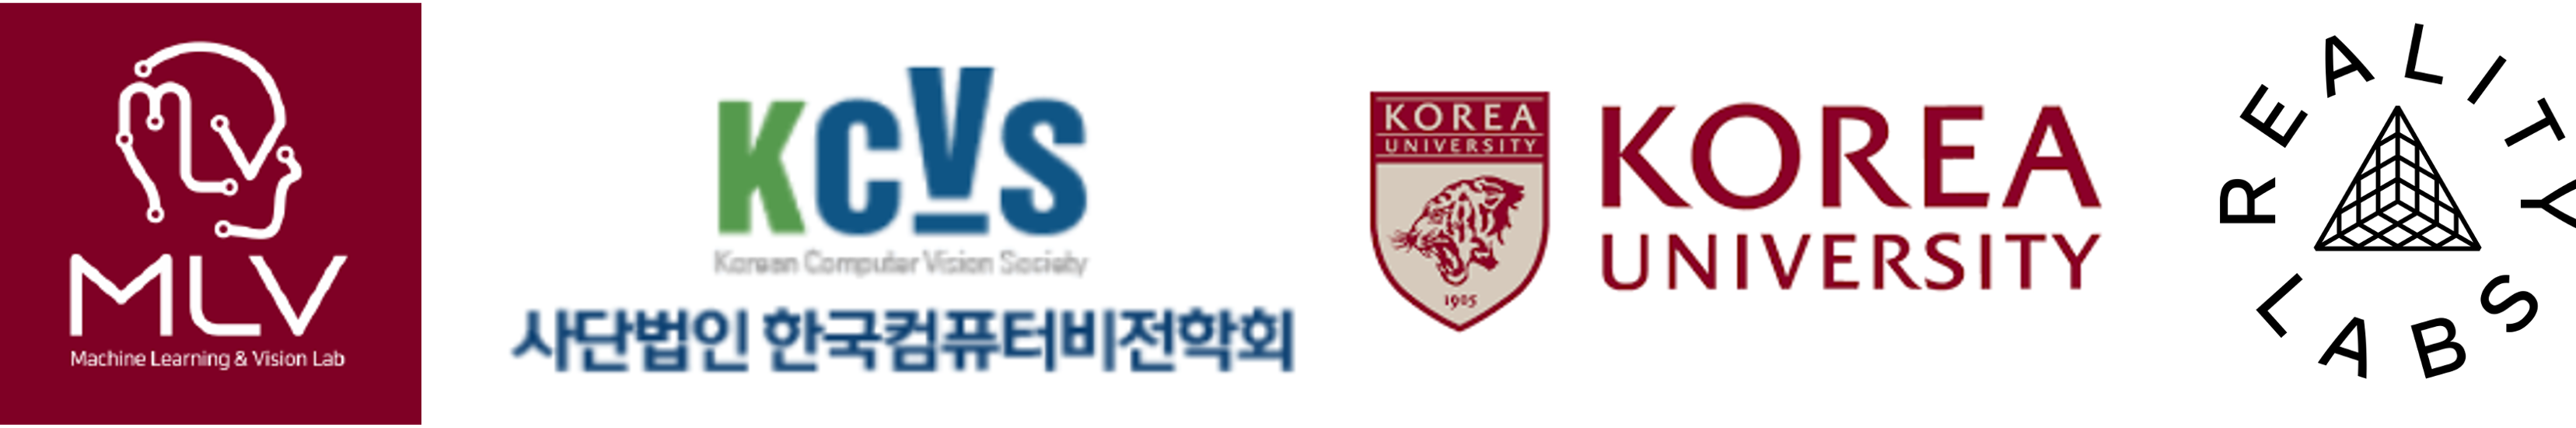

## SageMix: Saliency-Guided Mixup for Point Clouds

[[paper](https://arxiv.org/pdf/2210.06944.pdf)][[github](https://github.com/mlvlab/SageMix)]

Sanghyeok Lee, Minkyu Jeon, Injae Kim, Yunyang Xiong, Hyunwoo J. Kim


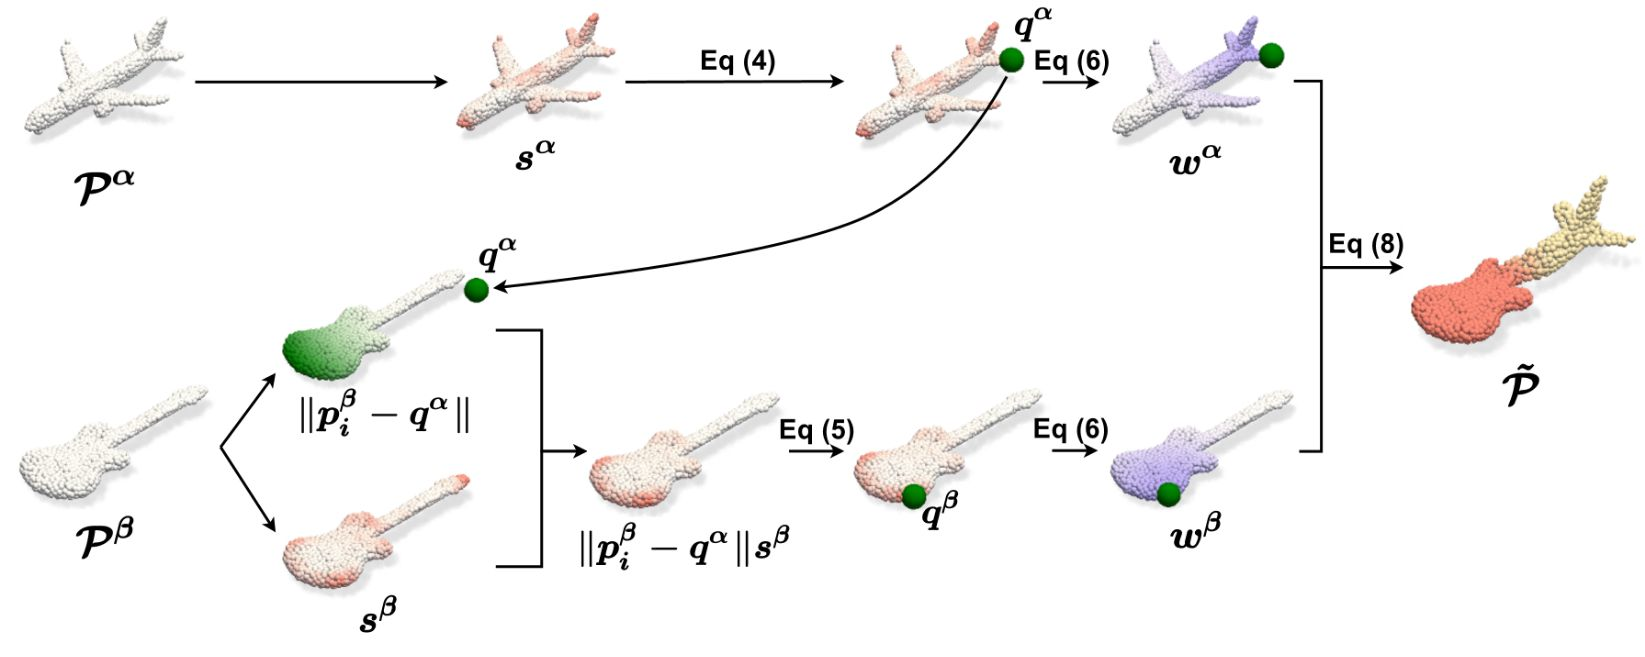

---
## 실습 내용 : SageMix를 사용한 Augmented Sample 생성
### Steps:
#### [1] Saliency Map in Point Cloud
#### [2] Saliency-guided Sequential Sampling
#### [3] Shape-preserving continuous Mixup
#### [+] Qualitative analyses on prior factor $\pi$ and the bandwidth $\sigma$

---
### 사전 작업

#### 1. github clone

In [ ]:
!git clone https://github.com/mlvlab/SageMix

#### 2. Requiremetns 설치

In [ ]:
%cd /content/SageMix/pointcloud


import warnings
warnings.filterwarnings( 'ignore' )

!pip install -r requirements.txt

#### 3. Visualization 라이브러리 설치 (pyvista) 및 함수 구현

In [ ]:
!pip install pyvista[all]
!sudo apt install libgl1-mesa-glx xvfb

#### 4. Visualization 확인

In [ ]:
import pyvista as pv
import numpy as np
import torch
from matplotlib.colors import ListedColormap

from data import ModelNet40
from model import knn


pv.start_xvfb()

#colormap
s_color = np.array([255, 255, 255, 255])/255
e_color = np.array([255, 140, 125, 255])/255
lin = np.linspace(0,1,256)
np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
color_map = np.expand_dims(s_color,1) + np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
cmap = ListedColormap(color_map.transpose((1,0)))


def visualize(point_cloud, y=None, query_points=None, q_color="G", text=None):
    plotter = pv.Plotter(notebook=True, shape=(1,1), window_size=[512,512])
    camera_pos = [1,-1,1]

    plotter.background_color = "White"

    if type(point_cloud) != np.ndarray:
        point_cloud = point_cloud.numpy()

    point_cloud_vis = pv.PolyData(point_cloud[:,[0,2,1]])

    if y==None:
        point_cloud_vis['y'] = torch.zeros(len(point_cloud))
    else:
        point_cloud_vis['y'] = y.numpy()

    plotter.add_points(point_cloud_vis, point_size=25, render_points_as_spheres=True, cmap=cmap, opacity=1.0)

    if query_points !=None:
        query_points_vis = pv.PolyData(query_points.numpy()[:,[0,2,1]])
        plotter.add_points(query_points_vis, point_size=50, render_points_as_spheres=True, color=q_color, opacity=1.0)


    #draw shadow
    pos  = point_cloud[:,[0,2,1]].repeat(3, 0) 
    pos +=  np.random.rand(pos.shape[0],pos.shape[1])/20
    point_cloud_shadow = pv.PolyData(pos)

    origin = [0,0,pos[:,2].min() - 0.1]
    point_cloud_shadow = point_cloud_shadow.project_points_to_plane(origin=origin, normal=[0,0,-1])

    plotter.add_points(point_cloud_shadow, point_size=25, render_points_as_spheres=True,\
                        opacity=1.0, color = '#dddddd', lighting=False) 

    plotter.camera_position = camera_pos

    plotter.remove_scalar_bar()
    light = pv.Light(intensity=0.1, shadow_attenuation = 0)
    light.set_direction_angle(30,0)
    plotter.add_light(light)
    light = pv.Light(intensity=0.18, shadow_attenuation = 0)
    light.set_direction_angle(30,180)
    plotter.add_light(light)
    if text is not None:
      plotter.add_title(text, font='courier', color='k',
                     font_size=10)
    plotter.show()

def saliency_smoothing(point_clouds, y, k=15, pow=1):
    B, _, N = point_clouds.shape

    idx = knn(point_clouds, k)
    idx_base = torch.arange(0, B).view(-1, 1, 1)*N
    idx = idx + idx_base
    idx = idx.view(-1)

    y = y**pow
    new_y =  y.view(B*N, -1)[idx, :]
    new_y = new_y.view(B, N, k) 


    saliency = new_y.sum(-1)
    saliency = saliency/saliency.sum(-1, keepdim=True)

    return saliency

num_points=1024
dset = ModelNet40(partition='test', num_points=num_points)
print(dset[0][0].shape, dset[0][1].shape)

airplanes = [] #airplane
gutiars = [] #guitars

for sample in dset:
    if sample[1] == 0:
        airplanes.append(sample)
    if sample[1] == 17:
        gutiars.append(sample)

print(len(airplanes), len(gutiars))

In [ ]:
airplane_idx= 1
guitar_idx = 15

sample1=airplanes[airplane_idx]
sample2=gutiars[guitar_idx]

visualize(sample1[0], text="sample 1 : airplane")
visualize(sample2[0], text="sample 2 : guitar")

---
## [1] Saliency Map in Point Cloud
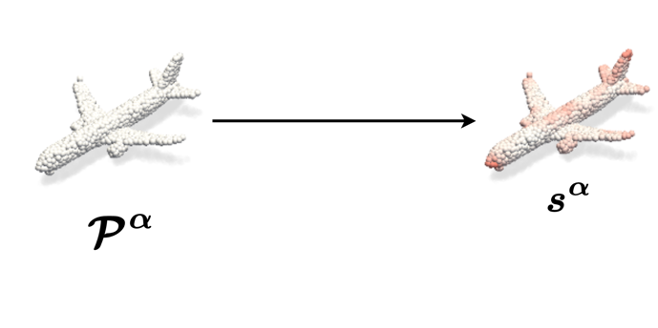
> $S^\alpha = \|\nabla_{P^\alpha} \ell(f(P^\alpha), y^\alpha)  \|$

> $P^\alpha$ : Point Cloud ($\mathbb{R}^{Nx3}$), N: Number of points

> $S^\alpha$ : Salincey scores for each point ($\mathbb{R}^{N}$)

> $f(\cdot)$ : Classifier, $y$ : Ground Truth, $\ell(\cdot, \cdot)$ : Cross-entropy loss

### 1. Pretrianed model 로드해오기


In [ ]:
import gdown
gdown.download_folder('https://drive.google.com/drive/folders/1pkEPJkpNoBcjBD5eaGtHAhcASwoHTygR?usp=sharing')

In [ ]:
#codes from main.py
import argparse
from collections import OrderedDict

from model import PointNet

#model parameters 
parser = argparse.ArgumentParser(description='Loading pretrained model')
parser.add_argument('--emb_dims', type=int, default=1024, metavar='N',
                    help='Dimension of embeddings')
parser.add_argument('--num_class', type=int, default=40, metavar='N',
                    help='Number of class')
args = parser.parse_args([])

#build model
model = PointNet(args, args.num_class)
# #load pretrained_model
# model = torch.nn.DataParallel(model)

try:
    loaded_state_dict = torch.load("model_saliency.t7",map_location=torch.device('cpu'))
except:
    loaded_state_dict = torch.load("KCCV_SageMix_weights/model_saliency.t7", map_location=torch.device('cpu'))


new_state_dict = OrderedDict()
for n, v in loaded_state_dict.items():
    name = n.replace("module.","")
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)

### 2. Forward & Backward



In [ ]:
from util import cal_loss
from torch.autograd import Variable

model.eval()

#예제 데이터
point_clouds = torch.tensor(np.stack([sample1[0],sample2[0]])) # (2x1024x3)
label = torch.tensor(np.stack([sample1[1],sample2[1]]))

#forward
point_clouds_var = Variable(point_clouds.permute(0,2,1), requires_grad=True)
logits = model(point_clouds_var)

#backward - calculate the gradient on the points.
loss = cal_loss(logits, label, smoothing=False)
loss.backward()

### 3. Calcuate the norm of the gradient

In [ ]:
#calculate the norm of the gradient
saliency = torch.sqrt(torch.mean(point_clouds_var.grad**2,1))
saliency = saliency_smoothing(point_clouds.permute(0,2,1), saliency)

#Visualize the results
visualize(sample1[0], y=saliency[0], text = "Saliency map of the airplane")
visualize(sample2[0], y=saliency[1], text = "Saliency map of the guitar")

---
## [2] Saliency-guided Sequential Sampling
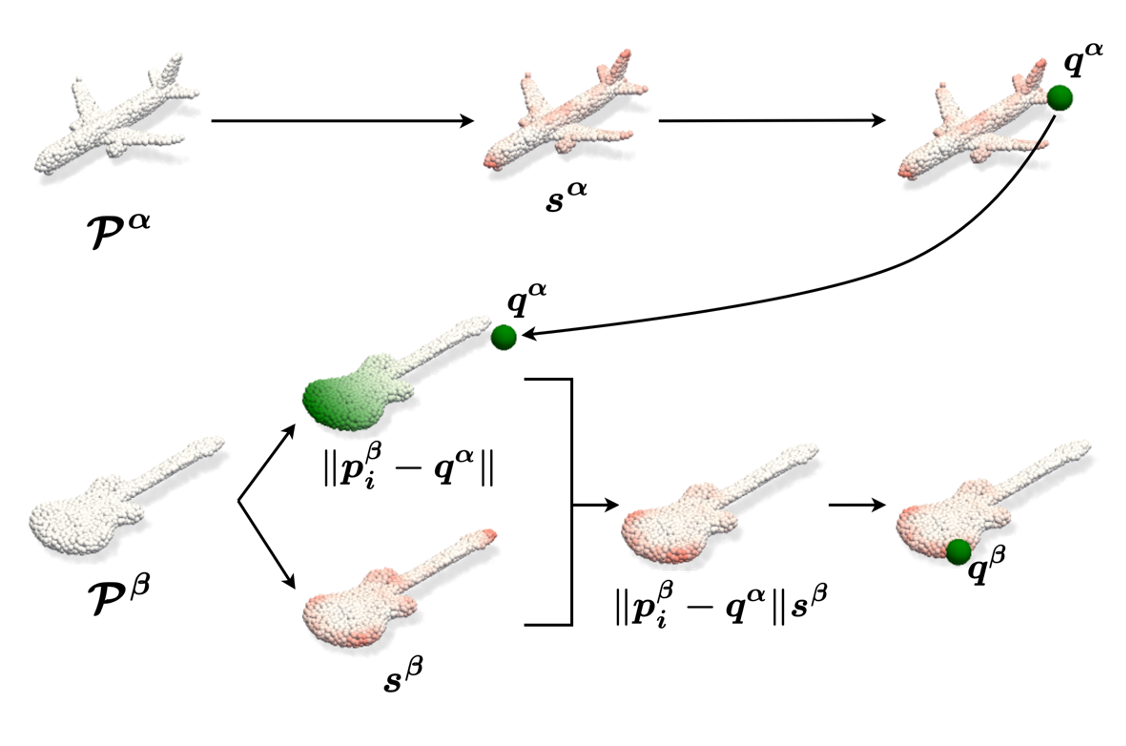

### 1. Select query point $q^\alpha$ for first sample $P^\alpha$ based on $S^\alpha$
> $\text{Pr}(I^\alpha=i) = \frac{s^\alpha_i}{\sum^N_is^\alpha_i}$

> $s^\alpha_i$ : saliency score of i-th point of $P^\alpha$

In [ ]:
#codebase from SageMix.py
xyz1 = point_clouds #(BxNx3)
B, _, _ =xyz1.shape


anc_idx = torch.multinomial(saliency, 1, replacement=True) #Above equation
anchor1 = xyz1[torch.arange(B), anc_idx[:,0]]

#visualize selected query point
visualize(xyz1[0], saliency[0], anchor1[0:1], text="Query point (green)\nfor the airplane")

### 2. Reweighting saliency map $S^\beta$ based on the distance to selected query point $q^\alpha$.
> $\|p^\beta_i - q^\alpha \|s^\beta_i$

> $p^\beta_i$ : i-th point in $P^\beta$

> $q^\alpha$ : query point in $P^\alpha$

> $s^\beta_i$ : saliency score of i-th point of $P^\beta$


In [ ]:
import scipy.optimize as optimize

#Align the point cloud(Details in PointMixup(https://arxiv.org/pdf/2008.06374.pdf))
xyz2 = xyz1[[1,0]]
dist = torch.bmm(xyz1,xyz2.permute(0,2,1))

ass = []
for i in range(B):
  ass.append(optimize.linear_sum_assignment(-dist[i])[1])
ass = np.stack(ass)

xyz2_temp = torch.zeros_like(xyz2)
saliency2 = torch.zeros_like(saliency)

for i in range(B):
    xyz2_temp[i] = xyz2[i][ass[i]]
    saliency2[i] = saliency[[1,0]][i][ass[i]]

xyz2 = xyz2_temp

#cal distance to query points
sub = xyz2 - anchor1[:,None,:]
dist = ((sub) ** 2).sum(2).sqrt()**2

# #reweighting saliency map 
saliency2 = saliency2 * dist
saliency2 = saliency2/saliency2.sum(-1, keepdim=True)

visualize(xyz1[1], saliency[1], anchor1[0:1], text="Original saliency map\nof the guitar")
visualize(xyz2[0], saliency2[0], anchor1[0:1], text="Reweighted saliency map\nof the guitar")

### 3. Select query point $q^\beta$ for second sample $P^\beta$ based on reweighted saliency map $\|p^\beta_i - q^\alpha\|s^\beta_i$.

In [ ]:
anc_idx2 = torch.multinomial(saliency2, 1, replacement=True)
anchor2 = xyz2[torch.arange(B),anc_idx2[:,0]]

# visualization
visualize(xyz2[0], saliency2[0], anchor2[0:1], q_color= "B", text="Query point (blue) for the guitar")

## [3] Shape-preserving continuous Mixup
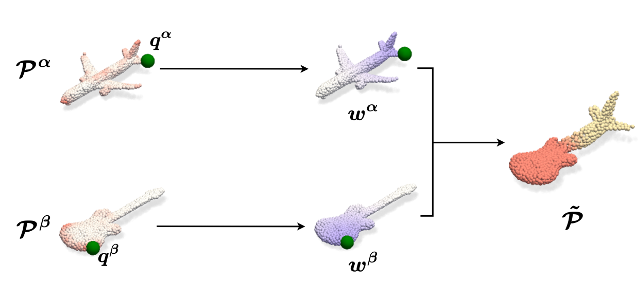

### 1. Calculate the weights $w$ with respect to the distance to query point $q$

$w^\alpha_i = K_\sigma(p^\alpha_i, q^\alpha) = exp\left(-\frac{\|p^t_i-q^t\|^2}{2\sigma^2}\right)$


$p^\alpha_i$ : i-th point in $P^\alpha$

$q^\alpha$ : query point for $P^\alpha$

$\sigma$ : kernel bandwidth






In [ ]:
sigma=0.3

#calculate the distance to query point in first sample
sub1 = xyz1 - anchor1[:,None,:]
dist1 = ((sub1) ** 2).sum(2).sqrt()
#calculate the weight based on the distance
weight1 = torch.exp(-0.5 * (dist1 ** 2) / (sigma ** 2))  


#calculate the distance to query point in second sample
sub2 = xyz2 - anchor2[:,None,:]
dist2 = ((sub2) ** 2).sum(2).sqrt()
#calculate the weight based on the distance
weight2 = torch.exp(-0.5 * (dist2 ** 2) / (sigma ** 2)) 

#visualize weight
visualize(xyz1[0], weight1[0], anchor1[0:1], text="Heat map for the airplane")
visualize(xyz2[0], weight2[0], anchor2[0:1],  q_color="B", text = "Heat map for the guitar")

### [2] interpolates two point clouds with weights $w^\alpha, w^\beta$

> $\lambda_i = \frac{w^\alpha_i}{w^\alpha_i + w^\beta_{\phi(i)}}$

> $\tilde{P} = \{\lambda_i p^\alpha_i + (1-\lambda_i)p^\beta_{\phi(i)}\}^N_i$

> $\phi(i)$ = mapping function between $P^\alpha$, $P^\beta$

In [ ]:
pi = 0.5
#calculate point-wise mixing ratio lambda
weight1 = weight1 * pi
weight2 = weight2 * (1-pi)
weight = (torch.cat([weight1[...,None],weight2[...,None]],-1)) + 1e-16
weight = weight/weight.sum(-1)[...,None]

#Mixing two point clouds based on mixing ratio
x = weight[:,:,0:1] * xyz1 + weight[:,:,1:] * xyz2

visualize(x[0], text = "Result")

## [+] Qualitative analyses on prior factor $\pi$ and the bandwidth $\sigma$

### 1. prior factor $\pi$
> $\lambda_i = \frac{\pi w^\alpha_i}{\pi w^\alpha_i + (1-\pi) w^\beta_{\phi(i)}}$

> $\pi$ : prior factor to control the entire mixup ratio from beta distribution.


In [ ]:
sigma=0.7

#calculate the distance to query point in first sample
sub1 = xyz1 - anchor1[:,None,:]
dist1 = ((sub1) ** 2).sum(2).sqrt()
#calculate the weight based on the distance
weight1 = torch.exp(-0.5 * (dist1 ** 2) / (sigma ** 2))  


#calculate the distance to query point in second sample
sub2 = xyz2 - anchor2[:,None,:]
dist2 = ((sub2) ** 2).sum(2).sqrt()
#calculate the weight based on the distance
weight2 = torch.exp(-0.5 * (dist2 ** 2) / (sigma ** 2)) 

for pi in [0.1,0.3,0.5,0.7,0.9]:
  #calculate point-wise mixing ratio lambda
  weight1 = weight1 * pi 
  weight2 = weight2 * (1-pi)
  weight = (torch.cat([weight1[...,None],weight2[...,None]],-1)) + 1e-16
  weight = weight/weight.sum(-1)[...,None]

  #Mixing two point clouds based on mixing ratio
  x = weight[:,:,0:1] * xyz1 + weight[:,:,1:] * xyz2

  visualize(x[0], text="pi = {}".format(pi))

2. Bandwidth $\sigma$ for gaussian kernel

> $w^\alpha_i = K_\sigma(p^\alpha_i, q^\alpha) = exp\left(-\frac{\|p^t_i-q^t\|^2}{2\sigma^2}\right)$

> $\sigma$ : kernel bandwidth

In [ ]:
for sigma in [0.1, 0.3, 0.5, 1.0, 2.0]:
  #calculate the distance to query point in first sample
  sub1 = xyz1 - anchor1[:,None,:]
  dist1 = ((sub1) ** 2).sum(2).sqrt()
  #calculate the weight based on the distance
  weight1 = torch.exp(-0.5 * (dist1 ** 2) / (sigma ** 2))  


  #calculate the distance to query point in second sample
  sub2 = xyz2 - anchor2[:,None,:]
  dist2 = ((sub2) ** 2).sum(2).sqrt()
  #calculate the weight based on the distance
  weight2 = torch.exp(-0.5 * (dist2 ** 2) / (sigma ** 2)) 

  pi = 0.5
  #calculate point-wise mixing ratio lambda
  weight1 = weight1 * pi 
  weight2 = weight2 * (1-pi)
  weight = (torch.cat([weight1[...,None],weight2[...,None]],-1)) + 1e-16
  weight = weight/weight.sum(-1)[...,None]

  #Mixing two point clouds based on mixing ratio
  x = weight[:,:,0:1] * xyz1 + weight[:,:,1:] * xyz2

  visualize(x[0], text="pi = {}".format(pi))

## Full code in SageMix.py
```
import torch
import emd_module

class SageMix:
    def __init__(self, args, num_class=40):
        self.num_class = num_class
        self.EMD = emd_module.emdModule()
        self.sigma = args.sigma
        self.beta = torch.distributions.beta.Beta(torch.tensor([args.theta]), torch.tensor([args.theta]))

    def mix(self, xyz, label, saliency=None):
        """
        Args:
            xyz (B,N,3)
            label (B)
            saliency (B,N): Defaults to None.
        """        
        B, N, _ = xyz.shape
        idxs = reversed(torch.arange(B))

        
        #Optimal assignment in Eq.(3)
        perm = xyz[idxs]
        
        _, ass = self.EMD(xyz, perm, 0.005, 500) # mapping
        ass = ass.long()
        perm_new = torch.zeros_like(perm).cuda()
        perm_saliency = torch.zeros_like(saliency).cuda()
        
        for i in range(B):
            perm_new[i] = perm[i][ass[i]]
            perm_saliency[i] = saliency[idxs][i][ass[i]]
        
        #####
        # Saliency-guided sequential sampling
        #####
        #Eq.(4) in the main paper
        saliency = saliency/saliency.sum(-1, keepdim=True)
        anc_idx = torch.multinomial(saliency, 1, replacement=True)
        anchor_ori = xyz[torch.arange(B), anc_idx[:,0]]
        
        #cal distance and reweighting saliency map for Eq.(5) in the main paper
        sub = perm_new - anchor_ori[:,None,:]
        dist = ((sub) ** 2).sum(2).sqrt()
        perm_saliency = perm_saliency * dist
        perm_saliency = perm_saliency/perm_saliency.sum(-1, keepdim=True)
        
        #Eq.(5) in the main paper
        anc_idx2 = torch.multinomial(perm_saliency, 1, replacement=True)
        anchor_perm = perm_new[torch.arange(B),anc_idx2[:,0]]
                
                
        #####
        # Shape-preserving continuous Mixup
        #####
        alpha = self.beta.sample((B,)).cuda()
        sub_ori = xyz - anchor_ori[:,None,:]
        sub_ori = ((sub_ori) ** 2).sum(2).sqrt()
        #Eq.(6) for first sample
        ker_weight_ori = torch.exp(-0.5 * (sub_ori ** 2) / (self.sigma ** 2))  #(M,N)
        
        sub_perm = perm_new - anchor_perm[:,None,:]
        sub_perm = ((sub_perm) ** 2).sum(2).sqrt()
        #Eq.(6) for second sample
        ker_weight_perm = torch.exp(-0.5 * (sub_perm ** 2) / (self.sigma ** 2))  #(M,N)
        
        #Eq.(9)
        weight_ori = ker_weight_ori * alpha 
        weight_perm = ker_weight_perm * (1-alpha)
        weight = (torch.cat([weight_ori[...,None],weight_perm[...,None]],-1)) + 1e-16
        weight = weight/weight.sum(-1)[...,None]

        #Eq.(8) for new sample
        x = weight[:,:,0:1] * xyz + weight[:,:,1:] * perm_new
        
        #Eq.(8) for new label
        target = weight.sum(1)
        target = target / target.sum(-1, keepdim=True)
        label_onehot = torch.zeros(B, self.num_class).cuda().scatter(1, label.view(-1, 1), 1)
        label_perm_onehot = label_onehot[idxs]
        label = target[:, 0, None] * label_onehot + target[:, 1, None] * label_perm_onehot 
        
        return x, label

```

